In [16]:
import pandas as pd
import numpy as np
from time import time
import os
import random
import xlrd
import xlwt
import pywt
import math
from scipy import optimize
import scipy
from sklearn import preprocessing
from tqdm import tqdm_notebook
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import manifold
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [35]:
# 背景扣除

def simulate_background(x):
    x = x.tolist()
    peak_list = find_peak(x)
    peak_position_list = [i for i, x in enumerate(x) if x in peak_list]
    min_list = [min(x[peak_position_list[i]:peak_position_list[i+1]]) for i in range(len(peak_position_list)-1)]
    min_new_list = min_list
    for index in range(1, len(min_list)-1, 1):
        if min_list[index] != 0:
            if min_list[index-1] != 0 and min_list[index+1] != 0:
                if min_list[index] > 1.2*min_list[index-1] and min_list[index] > 1.2*min_list[index+1]:
                    min_new_list[index] = 0.5*(min_list[index-1] + min_list[index+1])
    for index in range(len(peak_position_list)-1):
        x_change = x[peak_position_list[index]:peak_position_list[index+1]]
        x_change = [min_new_list[index] for i in range(len(x_change))]
        x[peak_position_list[index]:peak_position_list[index + 1]] = x_change
    x = np.array(x)
    return x

def find_peak(x):
    peak = []
    for index in range(1, len(x)-1, 1):
        if x[index-1] < x[index] and x[index] > x[index+1]:
            peak.append(x[index])
    return peak

def correct_background(x):
    x = np.maximum(x, 0)
    x = x-simulate_background(x)
    return x

def wavelet_de_noising(x, threshold=None):
    # Create wavelet object and define parameters
    w = pywt.Wavelet('haar')
    maxlev = pywt.dwt_max_level(len(x), w.dec_len)
    #print("maximum level is " + str(maxlev))
    threshold = threshold  # Threshold for filtering
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(x, 'haar', level=maxlev)  # 将信号进行小波分解
    #print(coeffs)
    for i in range(1, len(coeffs)):
        std_cache = np.std(coeffs[i], ddof=1)
        #print(std_cache)
        threshold_def = 3 * std_cache
        if threshold is None:
            coeffs[i] = pywt.threshold(coeffs[i], threshold_def)  # 将噪声滤波
        else:
            coeffs[i] = pywt.threshold(coeffs[i], threshold)  # 将噪声滤波
        #coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))  # 将噪声滤波
    #print(coeffs)
    datarec = pywt.waverec(coeffs, 'haar')  # 将信号进行小波重构
    return datarec

def remove_invalid_matrix(x, pixel, threshold=1000):
    x_column = x[:, pixel].tolist()
    valid_row_order = [i for i, x in enumerate(x_column) if x >= threshold]
    x = x[valid_row_order, :]
    return x

def mean_spectra_new(x, n, s):
    r_in, c_in = x.shape
    r_out = int((r_in+1-n)/s)
    x_out = np.zeros([r_out, c_in])
    for indexi in range(r_out):
        x_out[indexi, :] = np.mean(x[indexi*s:indexi*s+n, :], axis=0)
    return x_out

def plot_embedding(x, fig_name, path, color, text, title=None):  # text should be in str type; color in vale type
    x_min, x_max = np.min(x, 0), np.max(x, 0)
    x = (x - x_min) / (x_max - x_min)
    plt.ion()
    for index in range(x.shape[0]):
        plt.text(x[index, 0], x[index, 1],
                 text[index, 0],
                 color=plt.cm.tab20(color[index, 0]/(np.max(color)+1)),
                 fontdict={'weight': 'bold', 'size': 8})
    if title is not None:
        plt.title(title, fontsize=10)
    plt.savefig(path + '\\' + fig_name + '.png', dpi=1000, bbox_inches='tight')
    plt.pause(10)
    plt.close()
    
def find_highest_peak_position_2D(x):
    highest_peak = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] > highest_peak:
                highest_peak = x[i, j]
                highest_peak_position = [i, j]
    return highest_peak, highest_peak_position

def select_channels(x, select_horizon=20):
    highest_peak, highest_peak_position = find_highest_peak_position_2D(x)
    threshold = highest_peak / 2
    for i in range(1, select_horizon):
        if highest_peak_position[1] - i >= 0 and x[highest_peak_position[0], highest_peak_position[1] - i] < threshold:
            select_channel_bot = highest_peak_position[1] - i + 1
        elif highest_peak_position[1] - i < 0:
            select_channel_bot = 0
        if highest_peak_position[1] + i < x.shape[1] and x[highest_peak_position[0], highest_peak_position[1] + i] < threshold:
            select_channel_top = highest_peak_position[1] + i - 1
        elif highest_peak_position[1] + i == x.shape[1]:
            select_channel_top = x.shape[1] - 1
    return x[:, select_channel_bot:select_channel_top]
         
def cut_2D(x, cut_num, remove_duplicate=False):
    x_shape = np.array(x.shape)
    num = x.shape[0] * x.shape[1]
    x_cache = x.reshape(num)
    seq_num = np.zeros((cut_num, 1))
    x_sort = np.argsort(x_cache)
    print('x_sort.shape = ' + str(x_sort.shape))
    if remove_duplicate:
        if_cache = []
        removed_cache = []
        for i in tqdm_notebook(range(len(x_sort))):
            j = len(x_sort) - i - 1
            if x_cache[x_sort[j]] not in if_cache:
                if_cache.append(x_cache[x_sort[j]])
                print('x_cache[x_sort[j]] = '+str(x_cache[x_sort[j]]))
                removed_cache.append(x_sort[j])
        removed_cache = np.array(removed_cache).flatten()
        print('removed_cache.shape = ' + str(removed_cache.shape))
        #print('removed_cache = ' + str(removed_cache))
        x_sort = np.flip(removed_cache, 0)
        num2 = x_sort.shape[0]
        x_cache2 = np.zeros((num))
        for i in range(num2 - cut_num, num2):
            x_cache2[x_sort[i]] = x_cache[x_sort[i]]
        seq_num = x_sort[-cut_num:]
        print('seq_num = '+str(seq_num))
        return seq_num, x_cache2.reshape(x_shape)
    else:
        for i in range(num - cut_num):
            x_cache[x_sort[i]] = 0
        seq_num = x_sort[-cut_num:]
        return seq_num, x_cache.reshape(x_shape)         

def cut_1D(x, cut_num):
    x = x.flatten()
    x_sort = np.argsort(x)
    seq_num = x_sort[-cut_num:]
    return seq_num

def find_sequence(seq_num, shape=[4559, 127]):
    seq_cord = np.zeros((len(seq_num), 2))
    for j in range(len(seq_num)):
        for i in range(shape[0]):
            if seq_num[j] >= i*127 and seq_num[j] < (i+1)*shape[1]:
                seq_cord[j, :] = [i, seq_num[j]-i*shape[1]]
    return seq_cord

def find_peak_positions_2D(x):
    flag = True
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i == 0:
                left = 0
                right = x[i + 1, j]
            elif i == x.shape[0] - 1:
                left = x[i - 1, j]
                right = 0
            else:
                left = x[i - 1, j]
                right = x[i + 1, j]
            if j == 0:
                up = 0
                down = x[i, j + 1]
            elif j == x.shape[1] - 1:
                up = x[i, j - 1]
                down = 0
            else:
                up = x[i, j - 1]
                down = x[i, j + 1]
            if x[i, j] >= np.max([left, right, up, down]):
                if flag:
                    peak_pos = 127 * i + j
                    flag = False
                else:
                    peak_pos = np.row_stack((peak_pos, 127 * i + j))
    return peak_pos
            
def select_peaks(x, peak_pos, num):
    x_flat = x.reshape(-1, 1)
    x_cache = x_flat[peak_pos]
    print(x_cache.shape)
    x_sort = np.argsort(x_cache.flatten())
    print(x_sort)
    return peak_pos[x_sort[-num:]]

def dwt_coeffs_to_matrix(coeffs_in, structure, pixel_num):
    '''
    concerting coeffs from dwt to matrix through duplication.
    input:
        coeffs, vector
        strucrure, vector
    output:
        matrix, m*n, m is the number of channels including remaining, n is the number of pixels
    '''
    length = pixel_num
    level_num = len(structure) - 1
    final_coeffs = np.zeros((level_num + 1, length))
    coeffs = []
    num_tmp = 0
    for channel in range(level_num + 1):
        coeffs.append(coeffs_in[num_tmp: num_tmp + structure[channel]])
        num_tmp = num_tmp + structure[channel]
    coeffs = np.array(coeffs)
    for i in range(coeffs.shape[0]):
        coeffs_len = np.max(coeffs[i].shape)
        rem = length % coeffs_len # number of coeffs that need to be duplicated by (rep_num + 1)
        rep_num = length // coeffs_len # the other part of coeffs need to be duplicated by rep_num
        if rem != 0:
            cache = []
            for j in range(rem):
                for k in range(rep_num + 1):
                    cache.append(coeffs[i][j])
            for j in range(rem, coeffs_len):
                for k in range(rep_num):
                    cache.append(coeffs[i][j])
            final_coeffs[i] = cache
        else:
            cache = []
            for j in range(coeffs_len):
                for k in range(rep_num):
                    cache.append(coeffs[i][j])
            final_coeffs[i] = cache
    return final_coeffs

In [3]:
#preprocess
def preprocess_2020(x, if_correct_background=False, if_wavelet_de_noising=False, if_remove_invalid=False, 
                    if_mean=True, mean_num=[10, 5]):
    '''
    preprocess
    input: n*m array, meaning m spectra with n pixels
    attributes:
        mean_num: mean over mean_num[0] spectra, with interval of mean_num[1]
        if_header: if input data has pixels as headers
    output: array after preprocessing, transposition of input
    '''
    n = x.shape[0]
    m = x.shape[1]
    data = None
    for i in range(m):
        data_cache = x[:, i]
        if if_correct_background:
            data_cache = correct_background(data_cache)
        if if_wavelet_de_noising:
            data_cache = wavelet_de_noising(data_cache)
        if data is None:
            data = data_cache.T
        else:
            data = np.row_stack((data, data_cache.T))
    if if_remove_invalid:
        data = remove_invalid_matrix(data)
    if if_mean:
        data = mean_spectra_new(data, mean_num[0], mean_num[1])
    return data

def wavelet_transform_2020(x, t=None, totalscal=128, freq_output=False, method='cwt', level_max=None):
    '''
    wavelet_transform
    input: 1*n array, meaning 1 spectra with n pixels
    attribute:
        t: n*1, meaning n wavelengths with respect to n pixels
        totalscal: total number of scales
    output: coefficient matrix (and frequencies if freq_output)
    '''
    if method is 'cwt':
        if t is None:
            print('no freq input')
        sampling_space = (np.max(t) - np.min(t)) / len(t)
        wavename = 'cgau8'
        fc = pywt.central_frequency(wavename)
        cparam = 2 * fc * totalscal
        scales = cparam / np.arange(totalscal, 1, -1)
        [cwtmatr, frequencies] = pywt.cwt(x, scales, wavename, sampling_space)
        if freq_output:
            return abs(cwtmatr), frequencies
        else:
            return abs(cwtmatr)
    elif method is 'dwt':
        length = np.max(x.shape)
        wavename = 'db1'
        w = pywt.Wavelet(wavename)
        level_num = pywt.dwt_max_level(data_len=np.max(x.shape), filter_len=w.dec_len)
        if level_max is not None:
            if level_num > level_max:
                level_num = level_max
        coeffs = pywt.wavedec(x.flatten(), wavename, level=level_num)
        coeffs = np.array(coeffs)
        final_coeffs = np.zeros((level_num + 1, length))
        for i in range(coeffs.shape[0]):
            coeffs_len = np.max(coeffs[i].shape)
            rem = length % coeffs_len # number of coeffs that need to be duplicated by (rep_num + 1)
            rep_num = length // coeffs_len # the other part of coeffs need to be duplicated by rep_num
            if rem != 0:
                cache = []
                for j in range(rem):
                    for k in range(rep_num + 1):
                        cache.append(coeffs[i][j])
                for j in range(rem, coeffs_len):
                    for k in range(rep_num):
                        cache.append(coeffs[i][j])
                final_coeffs[i] = cache
            else:
                cache = []
                for j in range(coeffs_len):
                    for k in range(rep_num):
                        cache.append(coeffs[i][j])
                final_coeffs[i] = cache
        return final_coeffs, coeffs

In [ ]:
#preprocess and wavelet transform

point_number = 3
#file reading
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
process_path = ['RawSpectrum']
save_path_root = r'D:\data\china_2020\coeffs_dwt\coeffs'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for state in tqdm_notebook(['rock', 'pellet']):
    for i in tqdm_notebook(rock_type):
        for j in process_path:
            for z in range(point_number):
                data = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                data_processed = preprocess_2020(data[:, 1:]) #first column is pixel numbers
                for k in range(len(data_processed)):
                    save_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'.txt')
                    coeffs, orig_coeffs = wavelet_transform_2020(data_processed[k].flatten(), method='dwt')#, level_max=8
                    np.savetxt(save_path, coeffs)
                    file_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'_orig.txt')
                    if os.path.exists(file_path):
                        f = open(file_path, 'w')
                    else:
                        f = open(file_path, 'a+')
                    for coeff_num in range(len(orig_coeffs)):
                        for index_i in range(len(orig_coeffs[coeff_num])):
                            f.write(str(orig_coeffs[coeff_num][index_i])+' ')
                        f.write('\n')
                    f.close()
                    
structure = np.zeros((len(orig_coeffs)))
for coeff_num in range(len(orig_coeffs)):
    structure[coeff_num] = len(orig_coeffs[coeff_num])
np.savetxt(os.path.join(save_path_root, 'orig_coeffs_structure.txt'), structure, '%.0f')        

In [25]:
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
#feature selection

    data_file_path = r'D:\data\china_2020\coeffs_dwt\coeffs'
    menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
    structure = np.loadtxt(os.path.join(data_file_path, 'orig_coeffs_structure.txt'))
    point_number = 3
    save_path = os.path.join(r'D:\data\china_2020\result\scores', choose_element + '_dwt_orig')
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    process_path = ['RawSpectrum']
    choose_type = 'Soil_Type'
    file_list = 'Spectra_Name'
    sample_list = 'Spectra_Name'
    data_flag = pd.read_excel(menu_guide_path)
    file_names = np.array(data_flag[file_list])
    concentration = np.array(data_flag[choose_element])
    sample_type = np.array(data_flag[choose_type])
    sample_name_unique = np.array(data_flag[sample_list])
    train_test_set = np.array(data_flag['Train']).tolist()
    type_list = data_flag[choose_type].drop_duplicates(keep='first').tolist()
    ########################################################################################################################

    train_position = [1, 3, 12, 13, 21]
            
    # input for dwt
    for state in tqdm_notebook(['rock', 'pellet']):
        for process in process_path:
            X_tr = None
            for index_i in tqdm_notebook(train_position):
                for j in range(8):
                    data_point = 0
                    for i in range(point_number):
                        file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'_orig.txt'
                        read_path = os.path.join(data_file_path, file)
                        if not os.path.exists(read_path):
                            print(read_path)
                            continue
                        f=open(read_path,'r')
                        sourceInLine=f.readlines()
                        dataset=[]
                        for line in sourceInLine:
                            temp1=line.strip('\n')
                            temp2=temp1.split(' ')
                            dataset.append(temp2)
                        dataset = np.array(dataset)
                        for ii in range(dataset.shape[0]):
                            dataset[ii] = np.array(dataset[ii][:-1], dtype='float')
                        f.close()
                        data_cache = None
                        for ii in range(len(dataset)):
                            if data_cache is None:
                                data_cache = dataset[ii].reshape(1, -1)
                            else:
                                data_cache = np.column_stack((data_cache, dataset[ii].reshape(1, -1)))
                        np.savetxt(os.path.join(data_file_path, state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'_orig_flatten.txt'), data_cache)
                        data_point += data_cache
                    data_cache = data_point / point_number
                    if X_tr is None:
                        X_tr = data_cache
                        y_tr = concentration[index_i]
                    else:
                        X_tr = np.row_stack((X_tr, data_cache))
                        y_tr = np.row_stack((y_tr, concentration[index_i]))
            skb = SelectKBest(f_regression, k=X_tr.shape[1])
            X_tr = skb.fit_transform(X_tr, y_tr.ravel())
            score = skb.scores_
            score = score.tolist()
            for i in range(len(score)):
                if math.isnan(score[i]):
                    score[i] = 0
            np.savetxt(os.path.join(save_path, state + '_' + process + '.txt'), score)

    #cut data points
    cut_num = 100
    scores_path = save_path
    scores_pellet_Raw = np.loadtxt(os.path.join(scores_path, 'pellet_RawSpectrum.txt'))
    scores_rock_Raw = np.loadtxt(os.path.join(scores_path, 'rock_RawSpectrum.txt'))

    scores_pllt_rck_raw = np.multiply(scores_pellet_Raw, scores_rock_Raw)

    seq_num_cut = cut_1D(scores_pllt_rck_raw, cut_num)

    #cut data and take mean value over three points
    load_path_root = data_file_path
    rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
    save_path_root = os.path.join(r'D:\data\china_2020\coeffs_dwt\coeffs_cut', choose_element)
    if not os.path.exists(save_path_root):
        os.mkdir(save_path_root)
    for state in tqdm_notebook(['rock', 'pellet']):
        for i in tqdm_notebook(rock_type):
            for j in process_path:
                for k in range(8):
                    data_sum = 0
                    for z in range(point_number):
                        load_path = os.path.join(load_path_root, state+'_'+i+'_'+j+'_'+str(z+1)+'_'+str(k)+'_orig_flatten.txt')
                        data_cache = np.loadtxt(load_path)
                        data_sum += data_cache[seq_num_cut]
                    save_path = os.path.join(save_path_root, state+'_'+i+'_'+j+'_'+str(k)+'.txt')
                    np.savetxt(save_path, data_sum / point_number)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


C:\Users\yongq\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\yongq\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 176356
error = [1.78525768e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 206985
error = [-4.78269675e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 42473
error = [-1.48218278e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 106175
error = [-4.08492732e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 125082
error = [-4.91771828e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 346301
error = [-8.05386147e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 68442
error = [-3.14058264e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 22448
error = [-2.22652896e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 486004
error = [5.28920996e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 224204
error = [3.37467293e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 103992
error = [-3.19307317e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 92300
error = [4.92824265e-08]
indexi = 0
indexi = 1
batch_size = 1
k

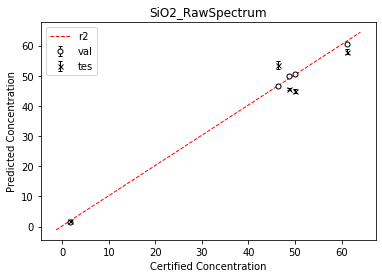

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [5.169040413857765, 5.192565736268883, 0.1008050068343566, nan, 0.565166442739056, 0.9987620100765917]
cal_true = ['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.7283364787968, 46.69760158898358, 60.472369629986105, 49.97298228821602, 1.643590404066551], ['cal_stander_derivation', 0.2777520136181499, 0.1907132905504397, 0.08271118348181457, 0.34788348586237655, 0.04443433588106617]]
cmp0 = [['cal_true', 50.05361889062726, 46.446884771709996, 61.08325733605639, 48.65117818601015, 1.6212885251308402], ['cal_predict', 50.7283364787968, 46.69760158898358, 60.472369629986105, 49.97298228821602, 1.643590404066551], ['cal_stander_derivation', 0.2777520136181499, 0.1907132905504397, 0.08271118348181457, 0.34788348586237655, 0.04443433588106

X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 182536
error = [8.65307992e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 37254
error = [-3.59908447e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 11009
error = [-4.21420802e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 3864
error = [-6.47456033e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 23850
error = [-4.11406443e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 45704
error = [-2.69937871e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 190880
error = [-3.93274437e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 247813
error = [-4.03965048e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 27575
error = [3.3260198e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 13796
error = [-2.13430219e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 6739
error = [6.51446408e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 328550
error = [3.26822882e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 1228

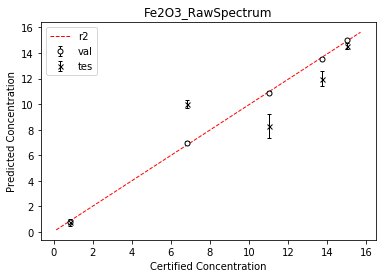

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.4128550725352884, 2.4088607140226013, 0.1948163797669363, nan, 0.19624646416939037, 0.9995380975295886]
cal_true = ['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.975108156570974, 10.907683387846026, 6.983672913928326, 13.565705623026936, 0.8097672739270148], ['cal_stander_derivation', 0.0017797427505174212, 0.10336476689608538, 0.09665156901212692, 0.07809656966483979, 0.04455901082312803]]
cmp0 = [['cal_true', 15.002104209397503, 11.035779821758295, 6.85, 13.720773625069198, 0.8436255066526641], ['cal_predict', 14.975108156570974, 10.907683387846026, 6.983672913928326, 13.565705623026936, 0.8097672739270148], ['cal_stander_derivation', 0.0017797427505174212, 0.10336476689608538, 0.09665156901212692, 0.07809656966483979, 0.04455901082312803]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 15146
error = [-4.76377552e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 251814
error = [-2.38334439e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 81866
error = [-7.46378293e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 135623
error = [3.45885689e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 311796
error = [1.11228649e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 95377
error = [-1.2579769e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 322786
error = [-4.59420496e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 55431
error = [-1.80109623e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 291072
error = [-9.52005919e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 129356
error = [2.00352904e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 151393
error = [-4.17410047e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 406900
error = [-4.22626028e-08]
indexi = 0
indexi = 1
batch_size = 1
k

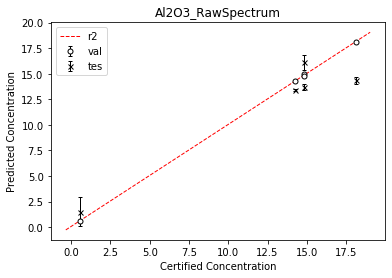

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.6660994989389755, 4.67822670298717, 0.4409688798763197, nan, 0.07949437230020784, 0.999893076236658]
cal_true = ['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.933483194375084, 18.142472523945557, 14.283805875188763, 14.8049867376007, 0.5952349812557685], ['cal_stander_derivation', 0.04467367623225251, 0.0007053344030507465, 0.027323628695888225, 0.0295331891756012, 0.029939083271023074]]
cmp0 = [['cal_true', 14.820345258118687, 18.150013433868214, 14.23, 14.837895986349137, 0.5381150351076665], ['cal_predict', 14.933483194375084, 18.142472523945557, 14.283805875188763, 14.8049867376007, 0.5952349812557685], ['cal_stander_derivation', 0.04467367623225251, 0.0007053344030507465, 0.027323628695888225, 0.0295331891756012, 0.029939083271023074]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 52206
error = [-4.30746843e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 359562
error = [4.9672543e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 155666
error = [3.03895589e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 267701
error = [-3.7890962e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 100966
error = [-2.64687169e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 29581
error = [-4.07575315e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 104472
error = [-2.03760223e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 97892
error = [-2.5254519e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 254719
error = [5.92142949e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 33156
error = [2.80593404e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 153403
error = [1.59364588e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 185447
error = [3.16569747e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 13

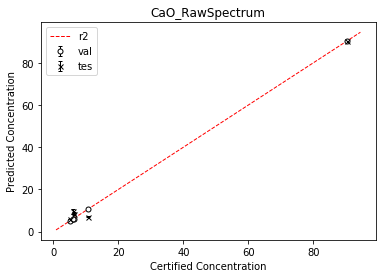

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [2.4264759465438077, 2.4280752296738677, 0.30286804847142745, nan, 0.11304585349731612, 0.9999967436370567]
cal_true = ['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 6.152532051627088, 10.80744394352134, 5.121259847146563, 5.872550535288875, 90.25171947434447], ['cal_stander_derivation', 0.02502963237139722, 0.09522290946584389, 0.03534412430094076, 0.032767282561812175, 5.6887784403159e-07]]
cmp0 = [['cal_true', 6.235730174642391, 10.73280321955514, 5.05, 5.892356771502109, 90.26445750193115], ['cal_predict', 6.152532051627088, 10.80744394352134, 5.121259847146563, 5.872550535288875, 90.25171947434447], ['cal_stander_derivation', 0.02502963237139722, 0.09522290946584389, 0.03534412430094076, 0.032767282561812175, 5.6887784403159e-07]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 140643
error = [-4.10902453e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 27982
error = [-2.08861096e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 110039
error = [2.12920495e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 214555
error = [-4.84167308e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 146318
error = [1.95747298e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 101244
error = [-7.62970032e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 67147
error = [-6.92376556e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 18905
error = [3.25922078e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 136381
error = [-4.75858184e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 115814
error = [-1.34417447e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 195519
error = [-5.58365654e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 187686
error = [-2.1485939e-08]
indexi = 0
indexi = 1
batch_size = 1


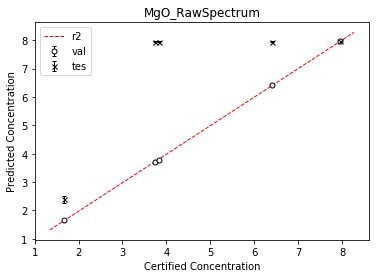

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [0.7128073012920882, 0.7135084972030409, 0.576450270562921, nan, 0.054098333007126624, 0.9998171072981975]
cal_true = ['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.7128481455289384, 7.959326711293717, 1.654931719781857, 3.7778743580347793, 6.427279916839175], ['cal_stander_derivation', 0.02551568061624202, 7.001688256010515e-06, 0.02077532092750896, 0.022349409875855226, 0.021967281900713627]]
cmp0 = [['cal_true', 3.733049230111028, 7.960281482413067, 1.66, 3.8378788656999205, 6.40530477273319], ['cal_predict', 3.7128481455289384, 7.959326711293717, 1.654931719781857, 3.7778743580347793, 6.427279916839175], ['cal_stander_derivation', 0.02551568061624202, 7.001688256010515e-06, 0.02077532092750896, 0.022349409875855226, 0.021967281900713627]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 140222
error = [-2.21305899e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 121898
error = [9.49776369e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 104032
error = [1.93505847e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 16332
error = [-4.69117615e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 55439
error = [-7.60702712e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 10380
error = [-4.27705787e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 25163
error = [3.88490847e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 154503
error = [-2.43737712e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 65263
error = [-3.61295861e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 44829
error = [-2.89757022e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 124360
error = [-2.94092576e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 94096
error = [1.252923e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 43

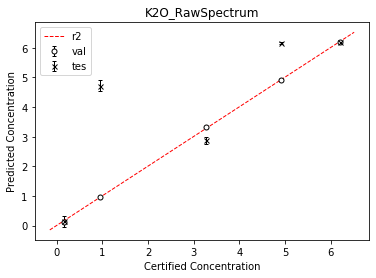

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [4.649989910335684, 4.67698334458971, 0.8763929853997892, nan, 0.053806648225916784, 0.9998679014424526]
cal_true = ['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 6.206128339706189, 0.977310609941102, 4.925964025268964, 3.316787329894718, 0.13016804478591193], ['cal_stander_derivation', 2.1480475257362742e-05, 0.017820239403375005, 0.037219113989296775, 0.023220212088701394, 0.011544297563518506]]
cmp0 = [['cal_true', 6.207767259061035, 0.9575203937552522, 4.92, 3.267190558532646, 0.15449109072445907], ['cal_predict', 6.206128339706189, 0.977310609941102, 4.925964025268964, 3.316787329894718, 0.13016804478591193], ['cal_stander_derivation', 2.1480475257362742e-05, 0.017820239403375005, 0.037219113989296775, 0.023220212088701394, 0.011544297563518506]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 272453
error = [-4.77870559e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 170623
error = [2.94990322e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 31776
error = [-4.15127264e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 29881
error = [-1.74474354e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 107396
error = [-2.8704265e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 217365
error = [1.02715958e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 135487
error = [-4.77409237e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 78845
error = [2.76400938e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 143109
error = [2.71228213e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 45766
error = [7.18192039e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 58423
error = [1.55512673e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 85937
error = [3.07976442e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 921

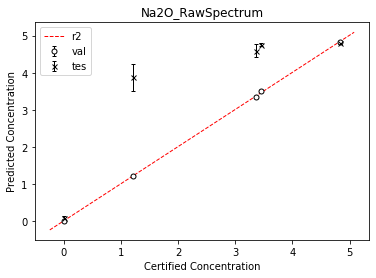

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.036743691379030045, 0.999789232035945]
cal_true = ['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.2286420414307329, 3.34224624491141, 3.502296546006725, 4.834343779559641, 0.002245407243811928], ['cal_stander_derivation', 0.02023903462684077, 0.0127346184728145, 0.02331702715636003, 4.351264580730874e-05, 0.004928548083758241]]
cmp0 = [['cal_true', 1.2163868277889867, 3.358467052723646, 3.45, 4.836583403242651, 0.0], ['cal_predict', 1.2286420414307329, 3.34224624491141, 3.502296546006725, 4.834343779559641, 0.002245407243811928], ['cal_stander_derivation', 0.02023903462684077, 0.0127346184728145, 0.02331702715636003, 4.351264580730874e-05, 0.004928548083758241]]



X_tr.shape = (40, 100)
y_tr.shape = (40, 1)
X_te.shape = (40, 100)
y_te.shape = (40, 1)
r0,c0 = 40, 100
batch_size = 1
k = 205001
error = [2.90443214e-09]
indexi = 0
indexi = 1
batch_size = 1
k = 81908
error = [-3.00740505e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 30716
error = [-2.72359686e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 53484
error = [5.06102049e-10]
indexi = 0
indexi = 1
batch_size = 1
k = 137963
error = [-1.82824546e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 182353
error = [-3.14490821e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 4348
error = [-4.08771602e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 160406
error = [-4.78576886e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 20070
error = [-4.27238958e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 166241
error = [1.9870715e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 198715
error = [-1.4667115e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 150091
error = [-1.31009786e-08]
indexi = 0
indexi = 1
batch_size = 1
k = 

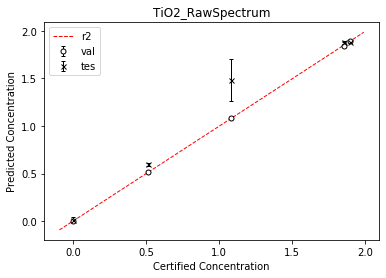

C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\yongq\Anaconda3\lib\site-packages\numpy\core\_methods.py:107: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


title = ['REC', 'RET', 'REP', 'RSD', 'LOD', 'R2']
value = [inf, inf, inf, nan, 0.01477573785447457, 0.9998746191399004]
cal_true = ['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8423130478458645, 0.512637299009776, 1.0883230305326719, 1.8968042818858535, -0.0016874606897275184], ['cal_stander_derivation', 0.009232926147307197, 0.003717385009715689, 0.009385151752267614, 2.8532226067033244e-05, 0.0021474965227938863]]
cmp0 = [['cal_true', 1.8595338861601751, 0.5116302999468363, 1.0818016135684754, 1.8975386213311878, 0.0], ['cal_predict', 1.8423130478458645, 0.512637299009776, 1.0883230305326719, 1.8968042818858535, -0.0016874606897275184], ['cal_stander_derivation', 0.009232926147307197, 0.003717385009715689, 0.009385151752267614, 2.8532226067033244e-05, 0.0021474965227938863]]




In [26]:
#!/usr/bin/python3
# coding: utf-8
import pandas as pd
import numpy as np
from time import time
import os
import random
import xlrd
import xlwt
import sys
from scipy import optimize
from tqdm import tqdm_notebook
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import manifold
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

########################################################################################################################
# 线性拟合
def f_1(x, a, b):
    return a * x + b

########################################################################################################################
# 除去重复
def remove_duplicate(x):  # the input should be the list style
    x = x.reshape(1, -1)
    x = x[0, :].tolist()
    output = []
    for i in x:
        if i not in output:
            output.append(i)
    return output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single(spectra):
    spectra_max = np.max(spectra, axis=1)
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra*spectra_mean/spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_1(spectra):
    wh = np.where(spectra == np.max(spectra))
    spectra_max = spectra[:, wh[1][0]]
    spectra_max = spectra_max.reshape(-1, 1)
    spectra_mean = np.mean(spectra_max)
    spectra_output = spectra * spectra_mean / spectra_max
    return spectra_output

########################################################################################################################
# 归一化同种样品的能量
def normalize_single_2(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    spectra_output = spectra * spectra_mean / spectra_mean_single
    return spectra_output

########################################################################################################################
# 归一化样品的能量
def normalize(spectra, group_set):
    X_output = np.zeros((spectra.shape[0], spectra.shape[1]))
    temp = remove_duplicate(group_set)
    group_set = group_set[:, 0].tolist()
    for indexj in range(len(temp)):
        temp_order = [i for i, x in enumerate(group_set) if x == temp[indexj]]
        X_temp = spectra[temp_order, :]
        X_temp = normalize_single_1(X_temp)
        X_output[temp_order] = X_temp
    return X_output

########################################################################################################################
# 归一化样品的能量
def normalize1(spectra):
    spectra_mean_single = np.mean(spectra, axis=1)
    spectra_mean_single = spectra_mean_single.reshape(-1, 1)
    spectra_mean = np.mean(spectra)
    X_output = spectra * spectra_mean / spectra_mean_single
    return X_output

########################################################################################################################
# 相对标准差
def relative_standard_derivation(x_predict, x_te):  # the imput should be the list style
    output = np.std((x_predict - x_te) / x_te) #* np.sqrt(len(x_te) / (len(x_te) - 1))
    return output

########################################################################################################################
# 相对偏差
def relative_error(x_predict, x_true):  # the imput should be the list style
    output = np.mean(abs(x_predict - x_true) / x_true)
    return output

########################################################################################################################
# limited of detection
def limited_of_detection(slope, rsd_calibration):
    output = 3 * np.mean(rsd_calibration) / slope
    return output

def relu(x):
    return np.maximum(x, 0.0)

def relu_deriv(x):
    x[x > 0] = 1.0
    x[x <= 0] = 0.0
    return x

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)*np.tanh(x)

def logistic(x):
    return 1/(1+np.exp(-x))

def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))

def prelu(x):
    return np.maximum(x, 0.0) + 0.25*np.minimum(x, 0.0)

def prelu_deriv(x):
    x[x > 0] = 1.0
    x[x < 0] = 0.25
    return x

class BPNNet:

    def __init__(self, layers, activation=["tanh", "tanh"], batch_size="None"):
        self.layers = layers
        # active function
        self.activation = activation
        if self.activation[0] == 'logistic':
            self.activation0 = logistic
            self.activation0_deriv = logistic_derivative
        elif self.activation[0] == 'tanh':
            self.activation0 = tanh
            self.activation0_deriv = tanh_deriv
        elif self.activation[0] == 'relu':
            self.activation0 = relu
            self.activation0_deriv = relu_deriv
        elif self.activation[0] == 'prelu':
            self.activation0 = prelu
            self.activation0_deriv = prelu_deriv
        if self.activation[1] == 'logistic':
            self.activation1 = logistic
            self.activation1_deriv = logistic_derivative
        elif self.activation[1] == 'tanh':
            self.activation1 = tanh
            self.activation1_deriv = tanh_deriv
        elif self.activation[1] == 'relu':
            self.activation1 = relu
            self.activation1_deriv = relu_deriv
        elif self.activation[1] == 'prelu':
            self.activation1 = prelu
            self.activation1_deriv = prelu_deriv
        # batch_size
        if batch_size == "None":
            self.batch_size = 0
        else:
            self.batch_size = batch_size
        # random weights & weights updates
        self.weights = []
        self.weights.append((2*np.random.random((layers[0]+1,layers[1]))-1)*0.25)
        for i in range(2,len(self.layers)):
            self.weights.append((2*np.random.random((layers[i - 1],layers[i])) - 1) * 0.25)
        # random weights & weights updates
        self.updates = []
        self.updates.append(np.zeros((self.layers[0] + 1, self.layers[1])))
        for i in range(2,len(self.layers)):
            self.updates.append(np.zeros((self.layers[i - 1], self.layers[i])))
    def fit(self, X, y, learning_rate_max=0.3, learning_rate_min=0.1, epochs=2000000, error_threshold=1e-8):  # learning_rate=0.2
        # self.weights 的数据更新
        self.weights[0] = (2*np.random.random((self.layers[0]+1, self.layers[1]))-1)*0.25
        for i in range(2, len(self.layers)):
            self.weights[i - 1] = (2*np.random.random((self.layers[i - 1],self.layers[i])) - 1) * 0.25
        #print(self.weights)
        # atlest_2d函数:确认X至少二位的矩阵
        X = np.atleast_2d(X)
        # 初始化矩阵全是1（行数，列数+1是为了有B这个偏向）
        temp = np.ones([X.shape[0], X.shape[1]+1])
        # 行全选，第一列到倒数第二列
        temp[:,0:-1]=X
        X = temp
        # 真实值的y数组
        y = np.array(y)
        # batch_size 的mini_batch计算
        batch_size = int(self.batch_size * X.shape[0])+1
        print('batch_size = '+str(batch_size))
        # epoch 每一次循环的BP
        for k in range(epochs):
            learning_rate = learning_rate_max - (learning_rate_max-learning_rate_min) * k/epochs
            # mini_batch 随机取出规定数目的序号list
            order = random.sample(range(X.shape[0]), batch_size)
            #print(order)
            # self.updates 的数据更新
            self.updates[0] = np.zeros((self.layers[0] + 1, self.layers[1]))
            for i in range(2, len(self.layers)):
                self.updates[i-1] = np.zeros((self.layers[i - 1], self.layers[i]))
            # print(self.updates)
            # mini_batch 梯度下降抽样
            error = 0
            error_cache = 1
            for j in range(batch_size):
                temp_j = order[j]
                # 根据order产生的随机数数列，循环每次一个样本
                a = [X[temp_j]]
                a.append(self.activation0(np.dot(a[0], self.weights[0])))
                a.append(self.activation1(np.dot(a[1], self.weights[1])))
                # 向前传播，得到每个节点的输出结果
                error_temp = y[temp_j] - a[-1]
                error += error_temp
            error = error/batch_size   # 最后一层错误率
            deltas = [error * self.activation1_deriv(a[-1])]
            deltas.append(deltas[-1].dot(self.weights[1].T) * self.activation0_deriv(a[1]))
            deltas.reverse()
            if abs(error) <= error_threshold:
                print('k = '+str(k))
                print('error = '+str(error))
                break
            elif k==epochs-1:
                self.weights = weights_cache
                print('iteration steps out of band')
                print('error = '+str(error_cache))
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.updates[i] += learning_rate * layer.T.dot(delta)
            for i in range(len(self.updates)):
                self.weights[i] += self.updates[i]/batch_size
            if error < error_cache:
                error_cache = error
                weights_cache = self.weights
    def predict(self, x):
        # x=np.array(x)
        r1, c1 = x.shape
        aa = np.ones(shape=[r1, 1])
        for indexi in range(r1):
            temp = np.ones(c1 + 1)
            temp[0:-1] = x[indexi].T
            a = temp
            a = self.activation0(np.dot(a, self.weights[0]))
            a = self.activation1(np.dot(a, self.weights[1]))
            aa[indexi] = a
        return (aa)
    def load_weights(self, path_load):
        '''''
        worksheet = xlrd.open_workbook(path_load)
        sheet_names = worksheet.sheet_names()
        '''''
        for indexi in range(len(self.weights)):
            data = pd.read_excel(path_load, sheet_name=str(indexi),
                                 header=0, skiprows=0)
            self.weights[indexi] = np.array(data)

    def save_weights(self, path_save):
        '''''
        workbook = xlwt.Workbook(encoding='ascii')

        for indexi in range(len(self.weights)):
            cmp = self.weights[indexi]
            worksheet = workbook.add_sheet(str(indexi))
            for i in range(len(cmp)):
                for j, k in enumerate(cmp[i]):
                    worksheet.write(i, j, k)
        workbook.save(path_save)
        '''''
        with pd.ExcelWriter(path_save) as writer:
            for indexi in range(len(self.weights)):
                print('indexi = '+str(indexi))
                data = self.weights[indexi]
                data = pd.DataFrame(data)
                data.to_excel(writer, sheet_name=str(indexi), index=False, header=False)
'''
    def rigidity_normalization(y, range0=range(300,320), range1=range(400,420)):
        peek0 = np.max(y[range0])
        peek1 = np.max(y[range1])
        rigidity = peek0 / peek1
        y = y / rigidity
        return y
'''
#  BPNNet
########################################################################################################################
#本部分可调
learning_rate_max_whole = 0.30
learning_rate_min_whole = 0.10
epochs_whole = 2000000
batch_size_whole = 0
threshold = 5e-8
########################################################################################################################
# active function

########################################################################################################################
date = '20191226'
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    for process in tqdm_notebook(['RawSpectrum']):
        try_num = 1
        #process = 'SmoothedSpectrum' #DenoisedSpectrum SmoothedSpectrum
        data_file_path = os.path.join(r'D:\data\china_2020\coeffs_dwt\coeffs_cut', choose_element)
        menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
        save_path_file = os.path.join(r'D:\data\china_2020\result\BPNN results', date, choose_element+'_'+str(try_num))
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        save_path_file = os.path.join(save_path_file, process)
        if not os.path.exists(save_path_file):
            os.mkdir(save_path_file)
        #process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
        choose_type = 'Soil_Type'
        file_list = 'Spectra_Name'
        sample_list = 'Spectra_Name'
        data_flag = pd.read_excel(menu_guide_path)
        file_names = np.array(data_flag[file_list])
        concentration = np.array(data_flag[choose_element])
        sample_type = np.array(data_flag[choose_type])
        sample_name_unique = np.array(data_flag[sample_list])
        train_test_set = np.array(data_flag['Train']).tolist()
        type_list = data_flag[choose_type].drop_duplicates(keep='first').tolist()
        p = 150  #p可调
        ########################################################################################################################
        # train list
        #train_position = [i for i, j in enumerate(train_test_set) if j == 1]
        train_position = [1, 3, 12, 13, 21]
        # test list
        #test_position = [i for i, j in enumerate(train_test_set) if j == 0]
        test_position = [1, 3, 12, 13, 21]
        ########################################################################################################################
        # Input Data

        state = 'pellet'
        X_tr = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                #data_cache = np.mean(data_cache, axis=0)
                if X_tr is None:
                    X_tr = data_cache
                    y_tr = temp_concentration
                    group_tr = index_i
                else:
                    X_tr = np.row_stack((X_tr, data_cache))
                    y_tr = np.row_stack((y_tr, temp_concentration))
                    group_tr = np.row_stack((group_tr, index_i))
        print('X_tr.shape = '+str(X_tr.shape))
        print('y_tr.shape = '+str(y_tr.shape))

        state = 'rock'
        X_te = None
        for index_i in train_position:
            temp_sample_type = type_list.index(sample_type[index_i])
            temp_sample_name = sample_name_unique[index_i]
            temp_concentration = concentration[index_i]
            for i in range(8):
                file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i)+'.txt'
                read_path = os.path.join(data_file_path, file)
                if not os.path.exists(read_path):
                    print(read_path)
                    continue
                data_cache = np.loadtxt(read_path)
                data_cache = data_cache.flatten()
                #data_cache = np.mean(data_cache, axis=0)
                if X_te is None:
                    X_te = data_cache
                    y_te = temp_concentration
                    group_te = index_i
                else:
                    X_te = np.row_stack((X_te, data_cache))
                    y_te = np.row_stack((y_te, temp_concentration))
                    group_te = np.row_stack((group_te, index_i))
        print('X_te.shape = '+str(X_te.shape))
        print('y_te.shape = '+str(y_te.shape))
        
        
        ########################################################################################################################
        # Te & Tr true concentration
        group_tr_remove_duplicate = remove_duplicate(group_tr)
        group_te_remove_duplicate = remove_duplicate(group_te)
        group_tr_temp = group_tr.reshape(1, -1)
        group_tr_temp = group_tr_temp[0, :].tolist()
        group_te_temp = group_te.reshape(1, -1)
        group_te_temp = group_te_temp[0, :].tolist()
        order_y_tr = [group_tr_temp.index(x) for x in group_tr_remove_duplicate]
        order_y_te = [group_te_temp.index(x) for x in group_te_remove_duplicate]
        y_tr_true = y_tr[order_y_tr,:]
        y_te_true = y_te[order_y_te,:]
        ########################################################################################################################
        # standard数据归一化
        '''
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        X_te = min_max_scaler1.transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        y_te = min_max_scaler2.transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        group_te_add = min_max_scaler3.transform(group_te)
        '''
        ########################################################################################################################
        # standard数据归一化for different states
        min_max_scaler1 = preprocessing.MinMaxScaler()
        X_tr = min_max_scaler1.fit_transform(X_tr)
        min_max_scaler1_te = preprocessing.MinMaxScaler()
        X_te = min_max_scaler1_te.fit_transform(X_te)
        min_max_scaler2 = preprocessing.MinMaxScaler()
        y_tr = min_max_scaler2.fit_transform(y_tr)
        min_max_scaler2_te = preprocessing.MinMaxScaler()
        y_te = min_max_scaler2_te.fit_transform(y_te)
        min_max_scaler3 = preprocessing.MinMaxScaler()
        group_tr_add = min_max_scaler3.fit_transform(group_tr)
        min_max_scaler3_te = preprocessing.MinMaxScaler()
        group_te_add = min_max_scaler3_te.fit_transform(group_te)
        ########################################################################################################################



        r0, c0 = X_tr.shape
        print('r0,c0 = '+str(r0)+', '+str(c0))
        ########################################################################################################################

        k = 6
        rr = 10

        predict_train_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_train_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp = np.empty(shape=[len(y_tr_true), k * rr])
        predict_val_temp_rsd = np.empty(shape=[len(y_tr_true), k * rr])
        predict_tes_temp = np.empty(shape=[len(y_te), k * rr])

        nn = BPNNet([c0, 5, 1], ['tanh','tanh'], batch_size_whole)   #神经元个数5-8
        '''''
        REtes = 0.4
        R2 = 0.97
        loop1 = 1oop2 = 1
        while REtes>0.30  or R2<0.998:
            print("loop1:")
            print(loop1)
        '''''
        rskf = RepeatedStratifiedKFold(n_splits=k, n_repeats=rr)
        combine = list(rskf.split(X_tr, group_tr))
        indexi = 0
        t0 = time()


        for train_index, val_index in combine:
            X_train = X_tr[train_index]
            y_train = y_tr[train_index]
            group_train = group_tr[train_index]
            X_val = X_tr[val_index]
            y_val = y_tr[val_index]
            group_val = group_tr[val_index]
            nn.fit(X_train, y_train, learning_rate_max=learning_rate_max_whole, learning_rate_min=learning_rate_min_whole, epochs=epochs_whole, error_threshold=threshold)
            nn.save_weights(save_path_file + r'\weights' + str(indexi) + '.xlsx')

            temp = nn.predict(X_train)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_train)
            group_train = group_train[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_train) if x == temp1[indexj]]
                predict_train_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_train_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_val)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            temp1 = remove_duplicate(group_val)
            group_val = group_val[:, 0].tolist()
            for indexj in range(len(temp1)):
                temp_order = [i for i, x in enumerate(group_val) if x == temp1[indexj]]
                predict_val_temp[indexj, indexi] = np.mean(temp[temp_order])
                predict_val_temp_rsd[indexj, indexi] = np.std(temp[temp_order])
                                                       #* np.sqrt(len(temp_order) / (len(temp_order) - 1))

            temp = nn.predict(X_te)
            #  inverse transform standard
            temp = min_max_scaler2.inverse_transform(temp)
            predict_tes_temp[:, indexi] = temp[:, 0]

            indexi += 1
        print("done in %0.3fs" % (time() - t0))
        # 作图使用的calibration val && validation set的predicted value & errorbar
        #  predicted value
        predict_train = np.mean(predict_train_temp, axis=1)
        predict_train_rsd = np.mean(predict_train_temp_rsd, axis=1)
        predict_val = np.mean(predict_val_temp, axis=1)  # 作图用的calibration线
        predict_val_rsd = np.mean(predict_val_temp_rsd, axis=1)  # 作图用的calibration线的errorbar
        # test data set
        predict_tes = np.mean(predict_tes_temp, axis=1)
        temp1 = remove_duplicate(group_te)
        predict_te = np.empty(shape=[len(temp1), 1])  # 作图用的validation线
        predict_te_rsd = np.empty(shape=[len(temp1), 1])  # 作图用的validation线的errorbar
        group_te = group_te[:, 0].tolist()
        for indexj in range(len(temp1)):
            temp_order = [i for i, x in enumerate(group_te) if x == temp1[indexj]]
            predict_te[indexj, 0] = np.mean(predict_tes[temp_order])
            predict_te_rsd[indexj, 0] = np.std(predict_tes[temp_order]) #* np.sqrt(len(temp_order) / (len(temp_order) - 1))
        # 文章计算Slope 截距
        print('predict_val = '+str(predict_val))
        Slope, intercept = optimize.curve_fit(f_1, y_tr_true[:, 0], predict_val)[0]
        # 文章简图
        nn0 = 10
        start = np.min(y_tr_true) - (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        stop = np.max(y_tr_true) + (np.max(y_tr_true) - np.min(y_tr_true)) / 20.0
        x1 = np.linspace(start, stop, num=nn0, endpoint=True)
        y1 = Slope * x1 + intercept  ##  拟合曲线
        plt.plot(x1, y1, color='r', linestyle='--', linewidth=1)
        plt.errorbar(y_tr_true, predict_val, yerr=predict_val_rsd, fmt='o', marker='o', mfc='white', mec='black', ms=5, mew=1,
                     ecolor='black', elinewidth=1, capsize=2)
        plt.errorbar(y_te_true, predict_te[:, 0], yerr=predict_te_rsd[:, 0], fmt='x', marker='x', mfc='white', mec='black',
                     ms=5, mew=1, ecolor='black', elinewidth=1, capsize=2)
        plt.legend(['r2', 'val', 'tes'],
                   loc='upper left',
                   numpoints=1,
                   fancybox=True)
        plt.xlabel('Certified Concentration')
        plt.ylabel('Predicted Concentration')
        plt.title(choose_element + '_' + process)
        plt.show()
        # 文章计算REC RET （使用y_tr_true）REP（使用y_te_true）
        REC = relative_error(predict_train, y_tr_true)
        RET = relative_error(predict_val, y_tr_true)
        REP = relative_error(predict_te, y_te_true)
        # 文章计算RSD(使用 predict_tes && y_te)
        RSD = relative_standard_derivation(predict_tes, y_te)
        # 文章计算LOD
        LOD = limited_of_detection(Slope, predict_val_rsd)
        # 文章计算R2（calibration曲线的r2）
        R2 = r2_score(predict_val, y_tr_true)
        ########################################################################################################################
        # print the results
        title = ["REC", "RET", "REP", "RSD", "LOD", "R2"]
        value = [REC, RET, REP, RSD, LOD, R2]
        print('title = '+str(title))
        print('value = '+str(value))
        ########################################################################################################################
        # save the results
        # Sheet 1
        # REC, RET, REP, RSD, LOD, R2 value
        cmp = [title, value]
        workbook = xlwt.Workbook(encoding='ascii')
        worksheet = workbook.add_sheet('Result')
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(i, j, k)
        # Sheet 2
        worksheet = workbook.add_sheet('Scatter')
        # calibration scatters value
        cal_true = ['cal_true']
        cal_predict = ['cal_predict']
        cal_stander_derivation = ['cal_stander_derivation']
        cal_true += y_tr_true[:,0].tolist()
        print('cal_true = '+str(cal_true))
        cal_predict += predict_val.tolist()
        cal_stander_derivation += predict_val_rsd.tolist()
        cmp0 = [cal_true, cal_predict, cal_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp0)):
            for j, k in enumerate(cmp0[i]):
                worksheet.write(j, i, k)
        # validation scatters value
        val_true = ['val_true']
        val_predict = ['val_predict']
        val_stander_derivation = ['val_stander_derivation']
        val_true += y_te_true[:, 0].tolist()
        val_predict += predict_te[:, 0].tolist()
        val_stander_derivation += predict_te_rsd[:, 0].tolist()
        cmp = [val_true, val_predict, val_stander_derivation]
        print('cmp0 = '+str(cmp0))
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i+len(cmp0), k)
        # Sheet 3
        worksheet = workbook.add_sheet('fitting')
        # fitting line value
        fitting_x = ["fitting_x"]
        fitting_y = ["fitting_y"]
        fitting_x += x1.tolist()
        fitting_y += y1.tolist()
        cmp = [fitting_x, fitting_y]
        for i in range(len(cmp)):
            for j, k in enumerate(cmp[i]):
                worksheet.write(j, i, k)
        workbook.save(os.path.join(save_path_file, r'result.xlsx'))



In [ ]:
#minus Dark for denoised and smoothed

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = ['S2', 'S5', 'S17', 'S19', 'S30']
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
save_path_root = r'D:\data\china_2020\pixel_select_corrected'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for state in tqdm_notebook(['rock', 'pellet']):
    for i in tqdm_notebook(rock_type):
        for j in process_path:
            for z in range(point_number):
                data_raw = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                data_dark = np.loadtxt(os.path.join(orig_path, i + '-' + state + '_' + 'RawSpectrum' + '_Dark_' + str(z + 1) + '.txt'))
                data_raw = data_raw[:, 1:]
                data_dark = data_dark[:, 1:].dot(np.ones((1, data_raw.shape[1])))
                data_correct = data_raw - data_dark
                np.savetxt(os.path.join(save_path_root, i + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'), data_correct, '%.5g')

In [ ]:
#preprocess and wavelet transform

point_number = 3
#file reading
#process_path = ['RawSpectrum_Dark', 'RawSpectrum_Raw', 'DenoisedSpectrum', 'SmoothedSpectrum']
menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
data_flag = pd.read_excel(menu_guide_path)
orig_path = r'D:\data\china_2020\pixel_select'
rock_type = {'1': 'S2', '3': 'S5', '12': 'S17', '13': 'S19', '21': 'S30'}
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum']
save_path_root = r'D:\data\china_2020\spectra_scores'
freq = np.loadtxt(r'D:\data\china_2020\pixel_wavelength.txt')
freq = freq[:, 1]
for choose_element in tqdm_notebook(['SiO2','Fe2O3','Al2O3','CaO','MgO','K2O','Na2O','TiO2']):
    concentration = np.array(data_flag[choose_element])
    for state in tqdm_notebook(['rock', 'pellet']):
        for j in process_path:
            X_tr = None
            for i in [1, 3, 12, 13, 21]:
                for z in range(point_number):
                    data = np.loadtxt(os.path.join(orig_path, rock_type[str(i)] + '-' + state + '_' + j + '_' + str(z + 1) + '.txt'))
                    data_processed = preprocess_2020(data[:, 1:]) #first column is pixel numbers
                    if X_tr is None:
                        X_tr = data_processed
                        y_tr = np.ones(8).reshape(-1, 1) * concentration[i]
                    else:
                        X_tr = np.row_stack((X_tr, data_processed))
                        y_tr = np.row_stack((y_tr, np.ones(8).reshape(-1, 1) * concentration[i]))
            skb = SelectKBest(f_regression, k=X_tr.shape[1])
            X_tr = skb.fit_transform(X_tr, y_tr.ravel())
            score = skb.scores_
            score = score.tolist()
            save_path = os.path.join(save_path_root, choose_element)
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            np.savetxt(os.path.join(save_path, state + '_' + j + '.txt'), score)
                    


In [ ]:
#for coeffs comparison
data_file_path = r'D:\data\china_2020\coeffs'
menu_guide_path = r'D:\data\Menu_Guide-quantitative.xlsx'
point_number = 3
process_path = ['DenoisedSpectrum', 'SmoothedSpectrum', 'RawSpectrum']
file_list = 'Spectra_Name'
data_flag = pd.read_excel(menu_guide_path)
file_names = np.array(data_flag[file_list])
########################################################################################################################

train_position = [1, 3, 12, 13, 21]
for state in tqdm_notebook(['rock', 'pellet']):
    for process in process_path:
        X_tr = None
        for index_i in tqdm_notebook(train_position):
            for j in range(8):
                data_point = 0
                for i in range(point_number):
                    file = state+'_'+file_names[index_i]+'_'+process+'_'+str(i+1)+'_'+str(j)+'.txt'
                    read_path = os.path.join(data_file_path, file)
                    if not os.path.exists(read_path):
                        print(read_path)
                        continue
                    data_point += np.loadtxt(read_path)
                data_cache = data_point / point_number
                np.savetxt(os.path.join(r'D:\data\china_2020\coeffs_mean', state+'_'+file_names[index_i]+'_'+process+'_'+str(j)+'.txt'), data_cache)